In [1]:
%load_ext autoreload
%autoreload 2

# Test partitioning update

In [2]:
from aerospace_chatbot.processing import DocumentProcessor
from aerospace_chatbot.services import EmbeddingService, RerankService, LLMService, DatabaseService, prompts
from aerospace_chatbot.processing import QAModel

# Load environment variables
from dotenv import load_dotenv
load_dotenv(override=True)
# Set LOCAL_DB_PATH environment variable
# os.environ['LOCAL_DB_PATH'] = os.path.abspath('.')

# Initialize logger
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [3]:
db_type='Pinecone'

embedding_service='OpenAI'
embedding_model='text-embedding-3-large'

rerank_service='Cohere'
rerank_model='rerank-v3.5'

llm_service='OpenAI'
llm_model='gpt-4o'
# llm_service='Anthropic'
# llm_model='claude-3-5-sonnet-latest'

chunk_size=400
chunk_overlap=0
batch_size=50
index_name = 'text-embedding-3-large-test'
rag_type = 'Standard'

test_prompt='How does a thermal knife function in a cable based hold down release mechanism?'

In [4]:
# Initialize services
embedding_service = EmbeddingService(
    model_service=embedding_service,
    model=embedding_model
)

rerank_service = RerankService(
    model_service=rerank_service,
    model=rerank_model
)

llm_service = LLMService(
    model_service=llm_service,
    model=llm_model,
)

doc_processor = DocumentProcessor(
    embedding_service=embedding_service,
    rag_type=rag_type,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

# Initialize database service
db_service = DatabaseService(
    db_type=db_type,
    index_name=index_name,
    rag_type=rag_type,
    embedding_service=embedding_service,
    rerank_service=rerank_service,
)

In [5]:
bucket_name = 'processing-pdfs'
docs = DocumentProcessor.list_bucket_pdfs(bucket_name)
docs

INFO:aerospace_chatbot.processing.documents:Number of PDFs found: 2
INFO:aerospace_chatbot.processing.documents:PDFs found: ['gs://processing-pdfs/1999_christiansen_reocr.pdf', 'gs://processing-pdfs/1999_cremers_reocr.pdf']


['gs://processing-pdfs/1999_christiansen_reocr.pdf',
 'gs://processing-pdfs/1999_cremers_reocr.pdf']

In [6]:
# partitioned_docs = doc_processor.load_and_partition_documents(docs,partition_by_api=False, upload_bucket=bucket_name)
# partitioned_docs

In [7]:
# chunk_obj, output_paths = doc_processor.chunk_documents(partitioned_docs)
# chunk_obj.chunk_convert(destination_type=Document)

In [8]:
try:
    db_service.initialize_database(clear=False)
except ValueError as e:
    print(f"Database initialization failed: {str(e)}")
    print(e)
    raise e

INFO:aerospace_chatbot.services.database:Validating index text-embedding-3-large-test and RAG type Standard
INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone
INFO:aerospace_chatbot.services.database:Pinecone index text-embedding-3-large-test found, not creating. Will be initialized with existing index.


In [9]:
# db_service.index_data(chunk_obj)

In [10]:
k_retrieve=20
k_rerank=5
config = {"configurable": {"thread_id": "1"}}

qa_model = QAModel(
    db_service=db_service,
    llm_service=llm_service,
    k_retrieve=k_retrieve,
    k_rerank=k_rerank,
    memory_config=config
)

In [11]:
# qa_model.query(test_prompt)

In [12]:
# print(qa_model.result[-1]['references'])
# print(qa_model.sources[-1])
# print(qa_model.scores[-1])


In [13]:
# print(qa_model.ai_response)

# Langgraph

Run above section first


In [14]:
from langchain_core.messages import SystemMessage, RemoveMessage
from langchain.output_parsers import PydanticOutputParser
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.documents import Document
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain.prompts import PromptTemplate

from typing_extensions import List
from typing import List, Literal, Tuple

# import cohere
# import os
from langchain.docstore.document import Document

from aerospace_chatbot.services.prompts import InLineCitationsResponse, AltQuestionsResponse, style_mode, CHATBOT_SYSTEM_PROMPT, QA_PROMPT, SUMMARIZE_TEXT, GENERATE_SIMILAR_QUESTIONS_W_CONTEXT

In [15]:
retriever = db_service.retriever
llm = llm_service.get_llm()
# memory = MemorySaver()

## Rerank

In [16]:
# Retrieve docs with standard retriever
retrieved_docs = retriever.invoke(test_prompt)

# retrieved_docs

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [17]:
# COHERE_API_KEY = os.getenv("COHERE_API_KEY")
# co = cohere.ClientV2(COHERE_API_KEY)
# rerank_model = "rerank-v3.5"

In [18]:
# model_list = co.models.list()
# rerank_model_info = next((model for model in model_list.models if model.name == rerank_model), None)
# print(rerank_model_info)

# print(model_list.models)

In [19]:
# Get token count for each doc
# max_context_length = 4096

# token_count_list = []
# for doc in retrieved_docs[0]:
#     tokens = co.tokenize(
#         model=rerank_model,
#         text=doc.page_content,
#     )
#     token_count_list.append(len(tokens.tokens))
    # print(token_count)

# print(token_count_list)

In [20]:
# def cohere_rerank(query: str, retrieved_docs: List[Tuple[Document, float]], top_n: int = None):
#     # retrieved_docs contains a list of tuples, where the first element is the document and the second is the score
#     # Cohere's rerank expects a list of strings; we'll supply the page_content

#     if top_n is None:
#         top_n = 3
#     elif top_n < 3:
#         raise ValueError("top_n must be at least 3")
#     elif top_n > len(retrieved_docs):
#         raise ValueError("top_n must be less than or equal to the number of retrieved documents")
    
#     inputs = [doc.page_content for doc, _ in retrieved_docs]

#     # Call Cohere's Rerank endpoint
#     response = co.rerank(
#         model=rerank_model,
#         query=query,
#         documents=inputs,
#         top_n=top_n
#     )

#     # Create a dictionary to map document IDs to rerank scores
#     rerank_scores = {retrieved_docs[i][0].id: item.relevance_score for i, item in enumerate(response.results)}

#     # Create list of (doc, original_score, rerank_score) tuples
#     doc_scores = []
#     for doc, original_score in retrieved_docs:
#         rerank_score = rerank_scores.get(doc.id, None)  # Get the rerank score or None if not available
#         doc_scores.append((doc, original_score, rerank_score))

#     # Sort docs by rerank score in descending order, placing those without a rerank score at the end
#     doc_scores_sorted = sorted(doc_scores, key=lambda x: (x[2] is not None, x[2]), reverse=True)

#     return doc_scores_sorted

In [21]:
reranked_docs = db_service.rerank(test_prompt, retrieved_docs, top_n=k_rerank)
# reranked_docs

INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


In [22]:
# Add context to the prompt
# TODO update this to use the doc.id. Do some testing to check this works.
docs_content=""
for i, (doc, original_score, rerank_score) in enumerate(reranked_docs):
    # Source IDs in the order they show in in the array. Indexed from 0.
    if rerank_score is not None:    # Only include docs with a rerank score
        docs_content += f"Source ID: {i+1}\n{doc.page_content}\n\n"

# print(docs_content)

## Test output parser

### InLineCitationsResponse

In [23]:
# Should validate
valid_response = InLineCitationsResponse(content="""
The actuator was tested under high pressure <source id="1">. 
Material properties were measured over 50 cycles <source id="2">.
Thermal resistance improved by 30% <source id="3">.
""",
citations=["1", "2", "3"]
)

print(valid_response)

content='\nThe actuator was tested under high pressure <source id="1">. \nMaterial properties were measured over 50 cycles <source id="2">.\nThermal resistance improved by 30% <source id="3">.\n' citations=['1', '2', '3']


In [24]:
# Shouldn't validate
try:
    invalid_response = InLineCitationsResponse(content="""
    The actuator was tested under high pressure [1]. 
    Material properties were measured under load <source id="x">.
    """,
    citations=["1", "x"]
    )
except ValueError as e:
    print(f"Validation failed: {e}")

Validation failed: 2 validation errors for InLineCitationsResponse
content
  Value error, No valid source tags found. Expected format: <source id="1"> [type=value_error, input_value='\n    The actuator was t... <source id="x">.\n    ', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error
citations
  Value error, No citations found in the content. Ensure sources are cited correctly. [type=value_error, input_value=['1', 'x'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error


In [25]:
QA_PROMPT_TEST=PromptTemplate(
    template=
"""
# **System Prompt**

Your name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering. You will function as a knowledgeable replacement for an expert in aerospace flight hardware design, testing, analysis, and certification.

> **Important Note:** The **Sources and Context** you are provided are ranked from most relevant to least relevant by a state-of-the-art retrieval and ranking tool. Please take this ranking into consideration when determining which sources to cite.

Use only the **Sources and Context** provided to answer the **User Question**. **Do not use outside knowledge**, and strictly follow these rules:

---

## **Rules**:

1. **Answer only based on the provided Sources and Context.**  
   - If the information is not available in the Sources and Context, respond with:  
     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*

2. **Do not make up or infer answers.**  
   - Stay accurate and factual at all times.

3. **Provide highly detailed, explanatory answers.**  
   - Include **as many specific details from the original context** as possible to thoroughly address the user’s question.

4. **Provide responses in English only** and format them using **Markdown** for clarity.

5. **Cite Sources in context** using the exact format `<source id="#">`:  
   - `#` – Represents the numerical order of the source as provided in the Sources and Context.  
   - **The `source` tag must be present for every source referenced in the response.**  
   - **Do not add, omit, or modify any part of the citation format.**  
   
   **Examples (Correct):**  
   > The actuator was tested under extreme conditions <source id="1">.  
   > A secondary material exhibited increased yield strength <source id="2">.  
   > Additional research confirmed thermal properties <source id="3">.  

   **Examples (Incorrect – Must Be Rejected):**  
   > Testing yielded higher efficiency [1] (Incorrect bracket format)  
   > <source id="1" > (Extra space after `id`)  
   > <source id="a"> (Non-numeric ID)  
   > <source id="1,2"> (Multiple IDs in one tag – invalid)  

6. **Every sentence or paragraph that uses a source must cite it with the format `<source id="#">`.**  
   - **Do not group multiple sources into a single tag.**  
   - Each source must have its own, clearly separated citation.  
   - For example:  
     > The actuator uses a reinforced composite structure <source id="1">.  
     > This design was validated through multiple tests <source id="2">.

7. **Validation Requirement:**  
   - If the response contains references without the exact `<source id="#">` format, the response must be flagged or rejected.  
   - Every source used must have a corresponding citation in the response.  
   - **No source should be referenced without explicit citation.**

8. **Suggest related or alternative questions** if applicable, to help the user find relevant information within the corpus.

9. **Give preference to citing top-ranked sources.**  
   - If the first sources in the list (i.e., the most relevant or highest-ranked) contain information that addresses the user’s question, cite them first.  
   - Then cite additional sources only if they contain new or non-redundant details.  
   - If the top-ranked sources are not relevant, skip them.

---
**Sources and Context**:
{context}
---

---
**User Question**:
{question}
---

---
{format_instructions}
---
""",
    input_variables=["context", "question"],
    partial_variables={"format_instructions": PydanticOutputParser(pydantic_object=InLineCitationsResponse).get_format_instructions()},
)


In [26]:
raw_output = llm.invoke(QA_PROMPT_TEST.format(context=docs_content, question=test_prompt))
print(raw_output.content)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


```json
{
  "content": "A thermal knife functions in a cable-based hold down release mechanism by cutting a wire bundle that holds the mechanism together. The thermal knife consists of a heater plate that is pushed through the wire bundle by a compression spring <source id=\"2\">. In this mechanism, there are two thermal knives for redundancy, both mounted onto a holddown bracket. They operate along the same center line, ensuring that their heater plates make contact at their cutting edges after cutting the wire bundle. To ensure precise contact, each thermal knife is attached to the holddown bracket at an angle of approximately 8° <source id=\"3\">. The cutting action of the thermal knife releases the pretensioned Dyneema wire bundle, which in turn releases the upper part of the Reel from the lower part, allowing the upper part to deploy <source id=\"5\">.",
  "citations": [
    "<source id=\"2\">",
    "<source id=\"3\">",
    "<source id=\"5\">"
  ]
}
```


In [27]:
parsed_response = PydanticOutputParser(pydantic_object=InLineCitationsResponse).parse(raw_output.content)
print(parsed_response)

content='A thermal knife functions in a cable-based hold down release mechanism by cutting a wire bundle that holds the mechanism together. The thermal knife consists of a heater plate that is pushed through the wire bundle by a compression spring <source id="2">. In this mechanism, there are two thermal knives for redundancy, both mounted onto a holddown bracket. They operate along the same center line, ensuring that their heater plates make contact at their cutting edges after cutting the wire bundle. To ensure precise contact, each thermal knife is attached to the holddown bracket at an angle of approximately 8° <source id="3">. The cutting action of the thermal knife releases the pretensioned Dyneema wire bundle, which in turn releases the upper part of the Reel from the lower part, allowing the upper part to deploy <source id="5">.' citations=['2', '3', '5']


### AltQuestionsResponse

In [28]:
# Should validate
valid_response = AltQuestionsResponse(
    questions=["What is the purpose of the actuator?", "What are the key components of the mechanism?", "How does the mechanism work?"],
)
print(valid_response)

questions=['What is the purpose of the actuator?', 'What are the key components of the mechanism?', 'How does the mechanism work?']


In [29]:
# Shouldn't validate
try:
    invalid_response = AltQuestionsResponse(
        questions=["What is the purpose of the actuator?", "What are the key components of the mechanism?"],
    )
except ValueError as e:
    print(f"Validation failed: {e}")

Validation failed: 1 validation error for AltQuestionsResponse
questions
  Value error, Expected exactly 3 questions, but got 2. [type=value_error, input_value=['What is the purpose of ...ents of the mechanism?'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error


In [30]:
raw_output = llm.invoke(GENERATE_SIMILAR_QUESTIONS_W_CONTEXT.format(context=docs_content, question=test_prompt))
print(raw_output.content)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


```json
{
  "questions": [
    "What role do Thermal Knives play in the operation of a cable-based hold down release mechanism?",
    "How does the design of the Thermal Knife ensure effective cutting of the Dyneema wire bundle in a hold down system?",
    "In what way does the Reel cable element enhance the functionality of a thermal knife in a hold down release mechanism?"
  ]
}
```


In [31]:
parsed_response = PydanticOutputParser(pydantic_object=AltQuestionsResponse).parse(raw_output.content)
print(parsed_response.questions)

['What role do Thermal Knives play in the operation of a cable-based hold down release mechanism?', 'How does the design of the Thermal Knife ensure effective cutting of the Dyneema wire bundle in a hold down system?', 'In what way does the Reel cable element enhance the functionality of a thermal knife in a hold down release mechanism?']


## Define graph

In [32]:
# class State(MessagesState):
#     context: List[Tuple[Document, float, float]]
#     cited_sources: List[Tuple[Document, float, float]]
#     summary: str

# # Define application steps
# def retrieve(state: State):
#     """
#     Retrieve the documents from the database.
#     """
#     logger.info(f"Node: retrieve")

#     # Retrieve docs
#     retrieved_docs = retriever.invoke(state["messages"][-1].content)
#     logger.info(f"Retrieved docs")
#     # Rerank docs
#     # reranked_docs = cohere_rerank(
#     #     state["messages"][-1].content, 
#     #     retrieved_docs, 
#     #     top_n=k_rerank
#     # )
#     reranked_docs = db_service.rerank(
#         state["messages"][-1].content, 
#         retrieved_docs, 
#         top_n=k_rerank
#     )
#     logger.info(f"Reranked docs")

#     return {"context": reranked_docs}

# def generate_w_context(state: State):
#     """
#     Call the model with the prompt with context.
#     """
#     logger.info(f"Node: generate_w_context")

#     # Get the summary, add system prompt
#     summary = state.get("summary", "")
#     system_prompt = CHATBOT_SYSTEM_PROMPT.format(style_mode=style_mode(style))
#     logger.info(f"generate_w_context system prompt: {system_prompt.content}")
#     if summary:
#         system_message = f"Summary of conversation earlier: {summary}"
#         messages = [system_prompt] + [SystemMessage(content=system_message)] + state["messages"]
#     else:
#         messages = [system_prompt] + state["messages"]

#     # Add context to the prompt
#     docs_content=""
#     for i, (doc, retrieved_score, rerank_score) in enumerate(state["context"]):
#         # Source IDs in the order they show in in the array. Indexed from 1, retrieve with 0 index.
#         if rerank_score is not None:    # Only include docs with a rerank score
#             docs_content += f"Source ID: {i+1}\n{doc.page_content}\n\n"

#     # Prompt with context and pydantic output parser
#     prompt_with_context = QA_PROMPT.format(
#         context=docs_content,
#         question=state["messages"][-1].content, 
#     )
#     # Replace the last message (user question) with the prompt with context, return LLM response
#     messages[-1] = prompt_with_context 
#     response = llm.invoke(messages)

#     # Parse the response. This will return a InLineCitationsResponse object. 
#     # This object has two fields: content and citations.
#     # Replace the last message with the content of the parsed and validated response. 
#     # AIMessage metadata will be incorrect.
#     parsed_response = PydanticOutputParser(pydantic_object=InLineCitationsResponse).parse(response.content)
#     response.content = parsed_response.content

#     # Return cited_sources as the list of tuples that matched the citations.
#     existing_cited_sources = state.get("cited_sources", [])  # Grab whatever might already be in cited_sources
#     cited_sources = [state["context"][int(citation)-1] for citation in parsed_response.citations]
#     existing_cited_sources.append(cited_sources)  # Append the new list as a sublist
#     state["cited_sources"] = existing_cited_sources

#     # Update the state messages with the messages updated in this node.
#     state["messages"] = messages
#     return {"messages": [response], 
#             "cited_sources": state["cited_sources"]}

# def should_continue(state: State) -> Literal["summarize_conversation", END]:
#     """
#     Define the logic for determining whether to end or summarize the conversation
#     """
#     logger.info(f"Node: should_continue")

#     # If there are more than six messages, then we summarize the conversation
#     messages = state["messages"]
#     if len(messages) > 6:
#         logger.info(f"Summarizing conversation")
#         return "summarize_conversation"
    
#     # Otherwise just end
#     logger.info(f"Ending conversation")
#     # logger.info(f"Messages before ending: {messages}")
#     return END

# def summarize_conversation(state: State):
#     """
#     Summarize the conversation
#     """
#     logger.info(f"Node: summarize_conversation")

#     summary = state.get("summary", "")
#     if summary:
#         # If a summary already exists, extend it
#         summary_message = SUMMARIZE_TEXT.format(
#             summary=summary,
#             augment="Extend the summary provided by taking into account the new messages above."
#         )
#     else:
#         # If no summary exists, create one
#         summary_text="""---\n**Conversation Summary to Date**:\n{summary}\n---"""
#         summary_message = SUMMARIZE_TEXT.format(
#             summary=summary_text,
#             augment="Create a summary of the conversation above."
#         )

#     messages = state["messages"] + [summary_message]
#     response = llm.invoke(messages)

#     # Prune messages. This deletes all but the last two messages
#     delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
#     return {"summary": response.content, "messages": delete_messages}

In [33]:
# # Compile application and test
# workflow = StateGraph(State)

# # Define nodes
# workflow.add_node("retrieve", retrieve) 
# workflow.add_node("generate_w_context", generate_w_context)
# workflow.add_node("summarize_conversation", summarize_conversation)

# # Define edges
# workflow.add_edge(START, "retrieve")
# workflow.add_edge("retrieve", "generate_w_context")

# # We now add a conditional edge
# workflow.add_conditional_edges(
#     "generate_w_context",   # Define the start node. We use `generate_w_context`. This means these are the edges taken after the `conversation` node is called.
#     should_continue,    # Next, pass in the function that will determine which node is called next.
# )

# # Add a normal edge from `summarize_conversation` to END. This means that after `summarize_conversation` is called, we end.
# workflow.add_edge("summarize_conversation", END)

# # Compile the workflow
# app = workflow.compile(checkpointer=memory)

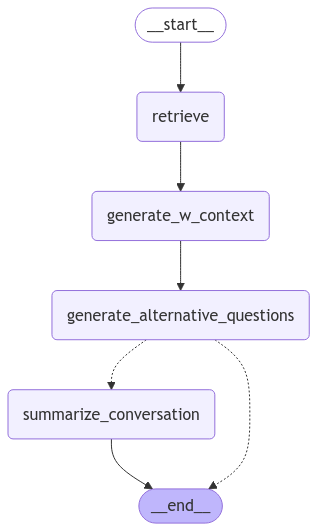

In [34]:
qa_model.workflow

## Run Graph

In [35]:
config = {"configurable": {"thread_id": "197"}}

In [36]:
prompt = 'My name is Dan. Please tell me about some interesting mecanism designs.'
result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

INFO:aerospace_chatbot.processing.queries:Node: retrieve
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:aerospace_chatbot.processing.queries:Retrieved docs
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:aerospace_chatbot.processing.queries:Reranked docs
INFO:aerospace_chatbot.processing.queries:Node: generate_w_context
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:aerospace_chatbot.processing.queries:Response generated
INFO:aerospace_chatbot.processing.queries:Response parsed
INFO:aerospace_chatbot.processing.queries:Node: generate_alternative_questions
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:aerospace_chatbot.processing.queries:Alternative questions generated.
INFO:aerospace_chatbot.processing.queries:Alternative questions parsed
INFO:aerospace_chatbot.processing.queries:Node: should_continue
INFO:ae

================================ Human Message =================================

My name is Dan. Please tell me about some interesting mecanism designs.
================================== Ai Message ==================================

One interesting mechanism design is the Multipurpose Holddown and Release Mechanism (MHRM) developed by Fokker Space. This mechanism is designed to utilize a very low energy signal to release a relatively large load. The design includes several components, such as a 'prime mover' that converts electrical energy into mechanical work. Among the components considered for this conversion are piezo-electric components, motors, solenoids, and shape memory alloy (SMA) components. The SMA, particularly in the form of wire, was chosen for its advantageous features. In this design, a wire 0.2 mm in diameter and 50 mm long was used <source id="2"><source id="4">.


In [150]:
# prompt = 'How have these mecahnisms been tested?'
prompt = 'How is release indicated from the functional response of the mechanism?'
result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

INFO:aerospace_chatbot.processing.queries:Node: retrieve
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:aerospace_chatbot.processing.queries:Retrieved docs
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:aerospace_chatbot.processing.queries:Reranked docs
INFO:aerospace_chatbot.processing.queries:Node: generate_w_context
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:aerospace_chatbot.processing.queries:Response generated
INFO:aerospace_chatbot.processing.queries:Response parsed
INFO:aerospace_chatbot.processing.queries:Node: generate_alternative_questions
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:aerospace_chatbot.processing.queries:Alternative questions generated.
INFO:aerospace_chatbot.processing.queries:Alternative questions parsed
INFO:aerospace_chatbot.processing.queries:Node: should_continue
INFO:ae

================================ Human Message =================================

My name is Dan. Please tell me about some interesting mecanism designs.
================================== Ai Message ==================================

One interesting mechanism design is the Multipurpose Holddown and Release Mechanism (MHRM) developed by Fokker Space. This mechanism is designed to utilize a very low energy signal to release a relatively large load. The design includes several components, such as a 'prime mover' that converts electrical energy into mechanical work. Among the components considered for this conversion are piezo-electric components, motors, solenoids, and shape memory alloy (SMA) components. The SMA, particularly in the form of wire, was chosen for its advantageous features. In this design, a wire 0.2 mm in diameter and 50 mm long was used <source id="2"><source id="4">.
================================ Human Message =================================

How have these mecahn

In [151]:
result

{'messages': [HumanMessage(content='My name is Dan. Please tell me about some interesting mecanism designs.', additional_kwargs={}, response_metadata={}, id='25541053-87e5-4430-a6d4-e767837ffb4f'),
  AIMessage(content='One interesting mechanism design is the Multipurpose Holddown and Release Mechanism (MHRM) developed by Fokker Space. This mechanism is designed to utilize a very low energy signal to release a relatively large load. The design includes several components, such as a \'prime mover\' that converts electrical energy into mechanical work. Among the components considered for this conversion are piezo-electric components, motors, solenoids, and shape memory alloy (SMA) components. The SMA, particularly in the form of wire, was chosen for its advantageous features. In this design, a wire 0.2 mm in diameter and 50 mm long was used <source id="2"><source id="4">.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 1

In [152]:
print(result['context'][0][0])

page_content='Release of the mechanism consists of rotating the latch arm with the SMA trigger wires until the toggles are no longer constrained radially. Once the latch arm has rotated clear, the toggles move outward and the outer race rotates toward the released position as described above. Figure 2 shows a cross section showing the basic latch components.' metadata={'chunk_overlap': 0.0, 'chunk_size': 400.0, 'data_source.record_locator.protocol': 'gs', 'data_source.record_locator.remote_file_path': 'gs://processing-pdfs', 'data_source.url': 'gs://processing-pdfs/1999_christiansen_reocr.pdf', 'element_id': '5464aae9-4a08-48cc-8e9f-4242570d6709', 'file_directory': './document_processing', 'filename': '1999_christiansen_reocr.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-12-26T14:30:38', 'orig_elements': 'eJx9Ustu2zAQ/BVC50SmHrYs33rprQ80uQWBsCbXEgGKFLhUHCPIv3dJOyjaoj3uzOzu7OPprUCLM7o4GF0cRLFtmtNJVlXb1HvVntS2Atxp2Ukpm1oqKO5EMWMEDRFY/1Yo74M2DiJSji1c/Bq

In [153]:
import json, base64, zlib

def extract_orig_elements(orig_elements):
    decoded_orig_elements = base64.b64decode(orig_elements)
    decompressed_orig_elements = zlib.decompress(decoded_orig_elements)
    return decompressed_orig_elements.decode('utf-8')

orig_elements = extract_orig_elements(result['context'][2][0].metadata['orig_elements'])
orig_elements = json.loads(orig_elements)
print(orig_elements)
print(len(orig_elements))

[{'element_id': 'b932f547aca1d250df6e8a9161d58899', 'metadata': {'coordinates': {'layout_height': 2200, 'layout_width': 1700, 'points': [[198.3, 964.2], [198.3, 1306.5], [828.4, 1306.5], [828.4, 964.2]], 'system': 'PixelSpace'}, 'data_source': {'record_locator': {'protocol': 'gs', 'remote_file_path': 'gs://processing-pdfs'}, 'url': 'gs://processing-pdfs/1999_christiansen_reocr.pdf'}, 'detection_class_prob': 0.95078, 'file_directory': './document_processing', 'filename': '1999_christiansen_reocr.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-12-26T14:30:38', 'page_number': 1, 'parent_id': 'fa24677bfd34adbb51118fc8b3aa9570'}, 'text': 'Separation nuts are a standard method used to release spacecraft deployable components. The segmented-nut design is simple, straightforward, and relatively easy to use. The nut segments are held together for retention of a bolt and then allowed to release through a mechanical action that is triggered on command. Assembly o

In [154]:
page_range = [orig_elements[0]['metadata']['page_number'], orig_elements[-1]['metadata']['page_number']]
print(page_range)

[1, 1]


In [155]:
from aerospace_chatbot.ui.utils import display_source_highlights

annotated_pdfs = display_source_highlights(result['context'][:k_rerank])
print(len(annotated_pdfs))

INFO:aerospace_chatbot.ui.utils:Extracted pdf from https://storage.googleapis.com/processing-pdfs/1999_christiansen_reocr.pdf for pages 1 to 3
INFO:aerospace_chatbot.ui.utils:Annotated pdf on extracted page 1
INFO:aerospace_chatbot.ui.utils:Extracted pdf from https://storage.googleapis.com/processing-pdfs/1999_christiansen_reocr.pdf for pages 3 to 4
INFO:aerospace_chatbot.ui.utils:Annotated pdf on extracted page 1
INFO:aerospace_chatbot.ui.utils:Annotated pdf on extracted page 1
INFO:aerospace_chatbot.ui.utils:Annotated pdf on extracted page 1
INFO:aerospace_chatbot.ui.utils:Extracted pdf from https://storage.googleapis.com/processing-pdfs/1999_christiansen_reocr.pdf for pages 0 to 1
INFO:aerospace_chatbot.ui.utils:Annotated pdf on extracted page 0
INFO:aerospace_chatbot.ui.utils:Extracted pdf from https://storage.googleapis.com/processing-pdfs/1999_christiansen_reocr.pdf for pages 0 to 2
INFO:aerospace_chatbot.ui.utils:Annotated pdf on extracted page 1
INFO:aerospace_chatbot.ui.utils:

5


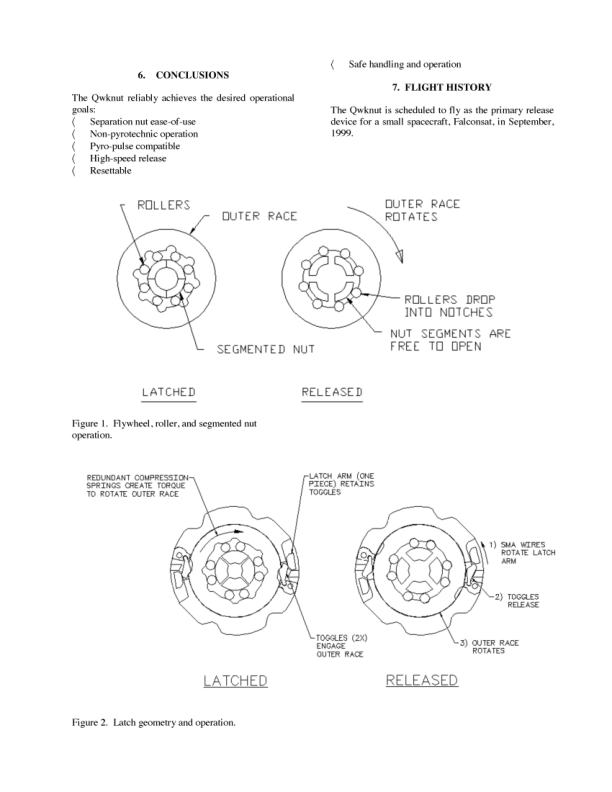

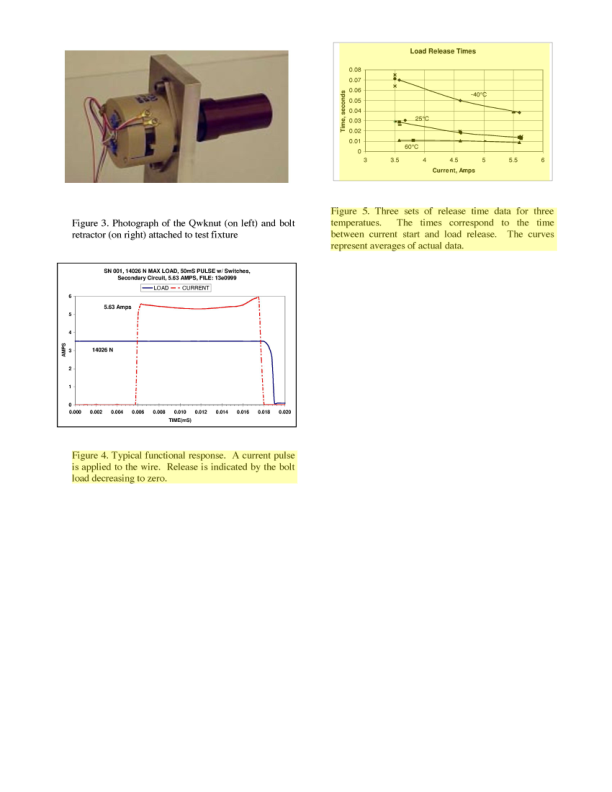

In [156]:
import fitz
from IPython.display import display, Image
from tempfile import NamedTemporaryFile

pdf_bytes = annotated_pdfs[1].read()
pdf_document = fitz.open(stream=pdf_bytes, filetype="pdf")

# Display each page
for page in pdf_document:
    pix = page.get_pixmap(matrix=fitz.Matrix(1, 1))  # 2x zoom for better resolution
    with NamedTemporaryFile(suffix='.png') as tmp:
        pix.save(tmp.name)
        display(Image(filename=tmp.name))

pdf_document.close()

## Summary memory test prompts

In [157]:
# prompt = 'How old are you?'
# result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
# for message in result['messages']:
#     message.pretty_print()

In [158]:
# prompt = 'What are some lessons learned about these mechanisms?'
# result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
# for message in result['messages']:
#     message.pretty_print()

In [159]:
# prompt = 'What are some problems that have occurred?'
# result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
# for message in result['messages']:
#     message.pretty_print()